In [357]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180115 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181213 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金

In [358]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np
import copy
########################################################################
# 策略继承CtaTemplate
#思路：LLT+AD判断趋势，蜡烛图提供进出场信号
class CDL_LLT_ADStrategy(CtaTemplate):
    """蜡烛图均线策略Demo"""
    className = 'CDL_LLT_ADStrategy'
    author = 'Qiudaokai'
    
    # 策略参数
    fastPeriod = 30   
    slowPeriod = 60
    stopLossPct = 0.02 #百分之二
    takeProfitPct = 0.02 #百分之二
    nPos = 0
    fixsize = 1
    Ratio = 0.03
    # 策略变量
    transactionPrice = {} # 记录成交价格
    maTrend = {} # 记录趋势状态，多头1，空头-1
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod',
                'stopLossPct',
                'takeProfitPct',
                'nPos',
                'fixsize',
                'Ratio']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把CDL_LLT_ADStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.intraTradeHighDict = {s: 0 for s in self.symbolList}
        self.intraTradeLowDict = {s: 999999 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        self.onBarStopLoss(bar)
        lastOrder=self.transactionPrice[symbol]        
        # 反马丁格尔加仓模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 3):    # 持有多头仓位并且加仓次数不超过3次
            if bar.close/lastOrder-1>= self.Ratio:   # 计算盈利比例,达到3%
                self.buy(symbol,bar.close*1.02,self.fixsize*(2**self.nPos))  # 加仓 1手、2手、3手
                self.nPos += 1  # 加仓次数减少 1 次
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 3):    # 持有空头仓位并且加仓次数不超过3次
            if lastOrder/bar.close-1 >= self.Ratio:   # 计算盈利比例,达到3%
                self.short(symbol,bar.close*0.98,self.fixsize*(2**self.nPos))  # 加仓 1手、2手、3手
                self.nPos += 1  # 加仓次数减少 1 次
        
        # 发出状态更新事件
        self.putEvent()
        
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
       # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopLossPct)
        longProfit = self.transactionPrice[symbol]*(1+3*self.takeProfitPct)
        shortStop = self.transactionPrice[symbol]*(1+self.stopLossPct)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.takeProfitPct)

        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
        
    #----------------------------------------------------------------------
    def LLT(self,closePrice,per):          #低延迟趋势线，经测试比MA/EMA更适合结合蜡烛图判断趋势
        close=copy.deepcopy(closePrice)       #深复制，原始对象的改变不会造成深拷贝里任何子元素的改变
        llt=copy.deepcopy(closePrice)
        mul=2.0/(per+1.0)
        for i in np.arange(2,len(llt)):    #从3开始，前两个用close赋值
            llt[i]=(mul-(mul*mul)/4)*close[i]+((mul*mul)/2)*close[i-1]-(mul-3*(mul*mul)/4)*close[i-2]+2*(1-mul)*llt[i-1]-(1-mul)*(1-mul)*llt[i-2]
        return llt
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am60 = self.getArrayManager(symbol, "60m")
        
        if not am60.inited:
            return
        
        fastMa = self.LLT(am60.close, self.fastPeriod)
        slowMa = self.LLT(am60.close, self.slowPeriod)
#         fastvMa = self.LLT(am60.volume, self.fastPeriod)
#         slowvMa = self.LLT(am60.volume, self.slowPeriod)
#         fastMa = ta.EMA(am60.close, self.fastPeriod)
#         slowMa = ta.EMA(am60.close, self.slowPeriod)
#         fastMa = ta.MA(am60.close, self.fastPeriod)
#         slowMa = ta.MA(am60.close, self.slowPeriod)

        AD = ta.AD(am60.high, am60.low, am60.close, am60.volume)
    
        #长短期均线及AD指标判断趋势
        if fastMa[-1] > slowMa[-1] and AD[-1] > AD[-2]:
            self.maTrend[symbol] = 1
        elif fastMa[-1] < slowMa[-1] and AD[-1] < AD[-2]:
            self.maTrend[symbol] = -1
            
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到15MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
 
        if not am15.inited:
            return
        
        hangingman = ta.CDLHANGINGMAN(am15.open.reshape(-1), am15.high.reshape(-1), am15.low.reshape(-1), am15.close.reshape(-1))
        invertedhammer = ta.CDLINVERTEDHAMMER(am15.open.reshape(-1), am15.high.reshape(-1), am15.low.reshape(-1), am15.close.reshape(-1))
        
        if invertedhammer[-1] == 100 and self.maTrend[symbol] == 1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.buy(symbol, bar.close*1.02, self.fixsize)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] >0:
                self.cancelAll()
                self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
                self.nPos = 0
                self.buy(symbol,bar.close*1.02, self.fixsize)

        # 死叉和金叉相反
        elif hangingman[-1] == -100 and self.maTrend[symbol] == -1 :
            if (self.posDict[symbol+'_LONG']==0) and (self.posDict[symbol+'_SHORT']==0):
                self.short(symbol,bar.close*0.98, self.fixsize)
            elif self.posDict[symbol+'_LONG'] >0:
                self.cancelAll()
                self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol,bar.close*0.98, self.fixsize)
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [359]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(CDL_LLT_ADStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function CDL_LLT_ADStrategy.on60MinBar at 0x0000023797B8F048>, <__main__.CDL_LLT_ADStrategy object at 0x00000237A41D16D8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function CDL_LLT_ADStrategy.on15MinBar at 0x0000023784A8AA60>, <__main__.CDL_LLT_ADStrategy object at 0x00000237A41D16D8>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function CDL_LLT_ADStrategy.onBar at 0x00000237918D5BF8>, <__main__.CDL_LLT_ADStrategy object at 0x00000237A41D16D8>)
2018-12-15 23:08:54.056887	开始回测
2018-12-15 23:08:54.056887	策略初始化
2018-12-15 23:08:54.057884	载入历史数据。数据范围:[20180107 04:00,20180115 12:00)
2018-12-15 23:08:54.445870	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-15 23:08:54.448875	载入完成，数据量：12000
2018-12-15 23:08:54.448875	策略初始化完成
2018-12-15 23:08:54.448875	策略启动完成
2018-12-15 23:08:54.448875	开始回放回测数据,回测范围:[20180115 12:00,20181213 12:00

Traceback (most recent call last):
  File "C:\Users\65766\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.13.dev1811227-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\Users\65766\Anaconda3\lib\site-packages\pandas\core\generic.py", line 2970, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180111080000 , 20180115110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的15mK线数据,时间起点为:20180115120000
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180114110000 , 20180115114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180115120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180115120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180115120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 13367.0, 'high': 13484.629999999999, 'low': 13338.21, 'close': 13460.0, 'date': '20180115', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 1, 15, 12, 0), 'volume': 94.180292999999992, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180114111500 , 20180115120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180115120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'ope

In [360]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf.tail(100)

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-09-29 23:00:00,空,,,0.0,,开仓,309,,6561.59,0.0,None,,,309,2018-09-29 23:00:00,1,309,BTCUSDT:binance,309
2018-10-02 13:15:00,多,,,0.0,,平仓,310,,6618.79,0.0,None,,,310,2018-10-02 13:15:00,1,310,BTCUSDT:binance,310
2018-10-02 13:15:00,多,,,0.0,,开仓,311,,6618.79,0.0,None,,,311,2018-10-02 13:15:00,1,311,BTCUSDT:binance,311
2018-10-03 10:26:00,空,,,0.0,,平仓,312,,6482.00,0.0,None,,,312,2018-10-03 10:26:00,1,312,BTCUSDT:binance,312
2018-10-04 10:15:00,多,,,0.0,,开仓,313,,6598.00,0.0,None,,,313,2018-10-04 10:15:00,1,313,BTCUSDT:binance,313
2018-10-04 15:45:00,空,,,0.0,,平仓,314,,6585.23,0.0,None,,,314,2018-10-04 15:45:00,1,314,BTCUSDT:binance,314
2018-10-04 15:45:00,空,,,0.0,,开仓,315,,6585.23,0.0,None,,,315,2018-10-04 15:45:00,1,315,BTCUSDT:binance,315
2018-10-09 13:30:00,多,,,0.0,,平仓,316,,6670.00,0.0,None,,,316,2018-10-09 13:30:00,1,316,BTCUSDT:binance,316
2018-10-09 13:30:00,多,,,0.0,,开仓,317,,6670.00,0.0,None,,,317,2018-10-09 13:30:00,1,317,BTCUSDT:binance,317


2018-12-15 23:09:49.347002	计算按日统计结果
2018-12-15 23:09:49.404843	------------------------------
2018-12-15 23:09:49.404843	首个交易日：	2018-01-15 00:00:00
2018-12-15 23:09:49.404843	最后交易日：	2018-12-13 00:00:00
2018-12-15 23:09:49.404843	总交易日：	333
2018-12-15 23:09:49.404843	盈利交易日	117
2018-12-15 23:09:49.404843	亏损交易日：	140
2018-12-15 23:09:49.404843	起始资金：	100000
2018-12-15 23:09:49.404843	结束资金：	134,448.23
2018-12-15 23:09:49.404843	总收益率：	34.45%
2018-12-15 23:09:49.404843	年化收益：	24.83%
2018-12-15 23:09:49.404843	总盈亏：	34,448.23
2018-12-15 23:09:49.404843	最大回撤: 	-2,539.2
2018-12-15 23:09:49.404843	百分比最大回撤: -2.5%
2018-12-15 23:09:49.405841	总手续费：	2,329.78
2018-12-15 23:09:49.405841	总滑点：	1.24
2018-12-15 23:09:49.405841	总成交金额：	4,659,565.76
2018-12-15 23:09:49.405841	总成交笔数：	408
2018-12-15 23:09:49.405841	日均盈亏：	103.45
2018-12-15 23:09:49.405841	日均手续费：	7.0
2018-12-15 23:09:49.405841	日均滑点：	0.0
2018-12-15 23:09:49.405841	日均成交金额：	13,992.69
2018-12-15 23:09:49.405841	日均成交笔数：	1.23
2018-12-15 23:09:49.405841	日均收益

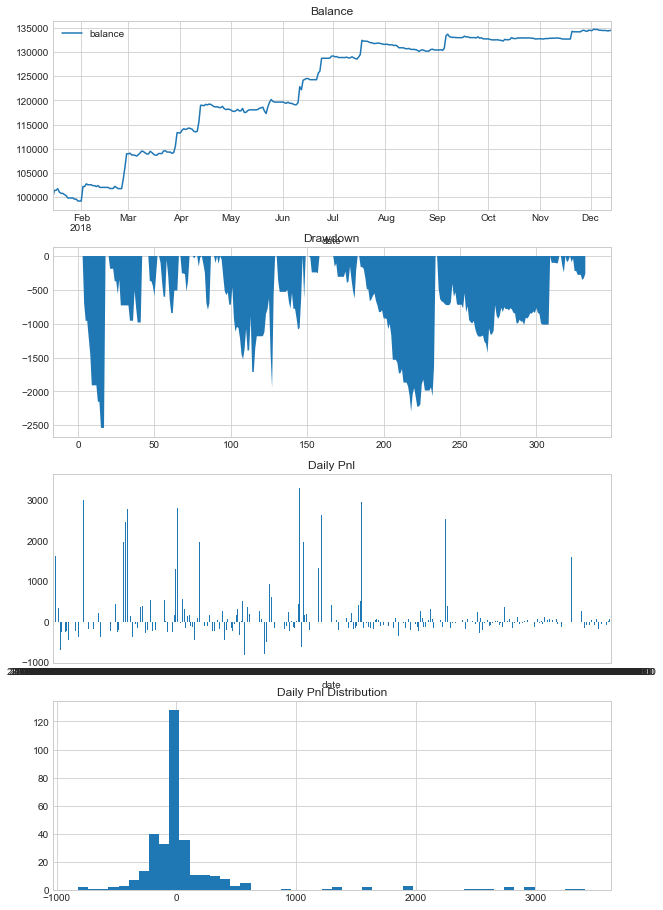

In [361]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-15 23:10:37.707076	计算回测结果
2018-12-15 23:10:37.733006	------------------------------
2018-12-15 23:10:37.733006	第一笔交易：	2018-01-15 19:44:00
2018-12-15 23:10:37.733006	最后一笔交易：	2018-12-13 11:58:00
2018-12-15 23:10:37.733006	总交易次数：	237
2018-12-15 23:10:37.733006	总盈亏：	34,446.52
2018-12-15 23:10:37.733006	最大回撤: 	-2,560.68
2018-12-15 23:10:37.733006	平均每笔盈利：	145.34
2018-12-15 23:10:37.733006	平均每笔滑点：	0.01
2018-12-15 23:10:37.733006	平均每笔佣金：	9.84
2018-12-15 23:10:37.733006	胜率		47.68%
2018-12-15 23:10:37.733006	盈利交易平均值	509.08
2018-12-15 23:10:37.733006	亏损交易平均值	-186.12
2018-12-15 23:10:37.733006	盈亏比：	2.74


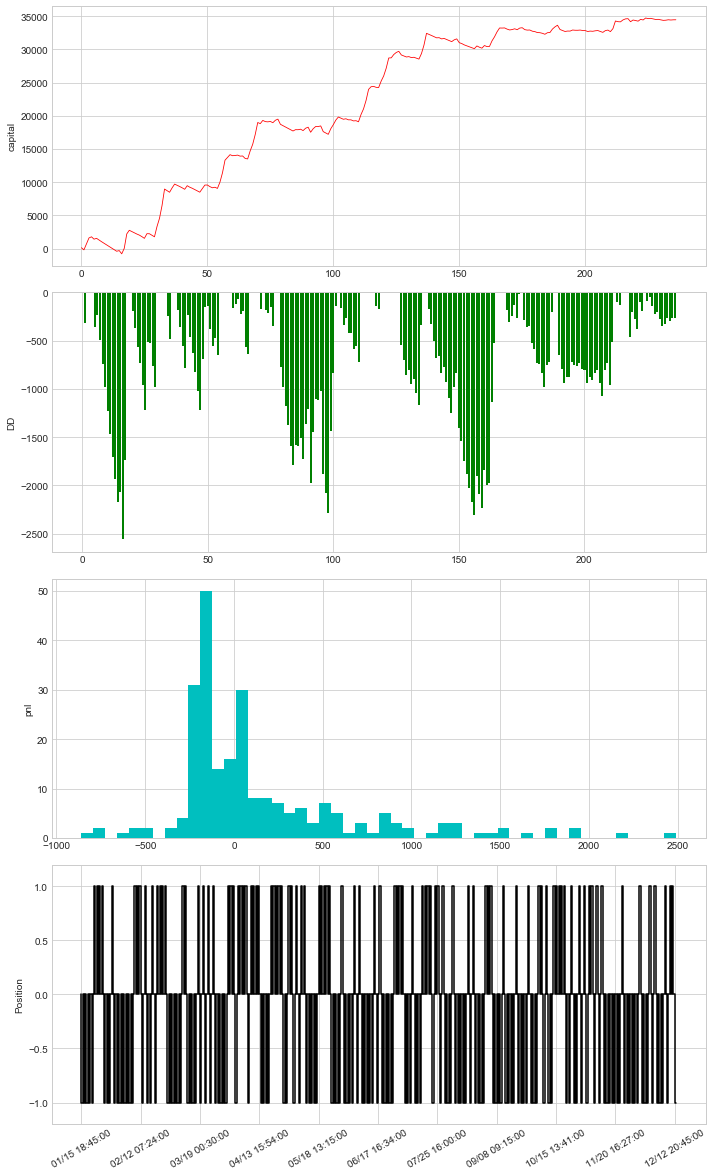

In [362]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [32]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')        # 设置优化排序的目标是夏普
# setting.addParameter('VWAPPeriod', 20, 80, 10)    # 增加第一个优化参数，起始30，结束50，步进10
# setting.addParameter('slowPeriod', 40, 80, 10)    # 增加第二个优化参数，起始60，结束30，步进10
# setting.addParameter('fastPeriod', 20, 30, 10)    # 增加第二个优化参数，起始10，结束30，步进5
setting.addParameter('trailingPct', 0.01, 0.1, 0.01)
setting.addParameter('symbolList', ['BTCUSDT:binance']) 
import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(CDL_LLT_ADStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
print('耗时：%s' %(time.time()-start))

2018-12-13 10:13:47.323362	------------------------------
2018-12-13 10:13:47.323362	setting: {'trailingPct': 0.01, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function CDL_LLT_ADStrategy.on60MinBar at 0x00000235F0D1A1E0>, <__main__.CDL_LLT_ADStrategy object at 0x00000235EEE0FC18>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function CDL_LLT_ADStrategy.on15MinBar at 0x00000235F0D1A488>, <__main__.CDL_LLT_ADStrategy object at 0x00000235EEE0FC18>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function CDL_LLT_ADStrategy.onBar at 0x00000235F0D1A8C8>, <__main__.CDL_LLT_ADStrategy object at 0x00000235EEE0FC18>)
2018-12-13 10:13:47.362261	开始回测
2018-12-13 10:13:47.362261	策略初始化
2018-12-13 10:13:47.363257	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-13 10:13:47.888851	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:13:47.893837	载入完成

2018-12-13 10:14:59.887097	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:14:59.944941	载入完成，数据量：261008
2018-12-13 10:14:59.944941	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-13 10:14:59.946902	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-13 10:15:00.091516	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:15:00.093509	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-13 10:15:00.114455	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-13 10:15:01.842830	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:15:01.853839	载入完成，数据量：53630
2018-12-13 10:15:01.858822	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-13 10:15:01.864774	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:15:01.864774	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000

[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531110000 , 20180601114500]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成15mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7483.4499999999998, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 294.76168100000001, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史15mK线更新，范围为:[20180531111500 , 20180601120000]
[INFO] 品种BTCUSDT:binance的15mK线准备就绪,当前K线时间为20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.0

2018-12-13 10:17:15.762984	数据回放结束ss: 100%    
2018-12-13 10:17:15.762984	计算按日统计结果
2018-12-13 10:17:15.888646	------------------------------
2018-12-13 10:17:15.888646	setting: {'trailingPct': 0.08, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function CDL_LLT_ADStrategy.on60MinBar at 0x00000235F0D1A8C8>, <__main__.CDL_LLT_ADStrategy object at 0x00000235EE094C18>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function CDL_LLT_ADStrategy.on15MinBar at 0x00000235F0D1A488>, <__main__.CDL_LLT_ADStrategy object at 0x00000235EE094C18>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function CDL_LLT_ADStrategy.onBar at 0x00000235F0D1AC80>, <__main__.CDL_LLT_ADStrategy object at 0x00000235EE094C18>)
2018-12-13 10:17:15.919564	开始回测
2018-12-13 10:17:15.919564	策略初始化
2018-12-13 10:17:15.920562	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-13 1

2018-12-13 10:18:15.129838	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:18:15.132831	载入完成，数据量：12000
2018-12-13 10:18:15.132831	策略初始化完成
2018-12-13 10:18:15.132831	策略启动完成
2018-12-13 10:18:15.133830	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-13 10:18:15.151778	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-13 10:18:23.349172	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:18:23.411041	载入完成，数据量：261008
2018-12-13 10:18:23.412005	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-13 10:18:23.414037	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-13 10:18:23.575567	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-13 10:18:23.575567	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-13 10:18:23.592523	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-13 10:1